In [70]:
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [35]:
#Importing the data
transform = transforms.Compose([transforms.ToTensor()])

traindata = datasets.MNIST(root='data', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(traindata, batch_size=64, shuffle=True)

In [29]:
#Generator Model
class Generator(nn.Module):
    def __init__(self, input_layer,hidden_layer, output_layer):
        super().__init__()
        
        self.fc1 = nn.Linear(input_layer,hidden_layer*4)
        self.fc2 = nn.Linear(hidden_layer*4,hidden_layer*2)
        self.fc3 = nn.Linear(hidden_layer*2,hidden_layer)
        self.fc4 = nn.Linear(hidden_layer,output_layer)
        
        self.dropout = nn.Dropout(p=0.3)
    
    def forward(self,x):
        
        x = F.leaky_relu(self.fc1(x),0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x),0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x),0,2)
        x = self.dropout(x)
        
        x = F.tanh(self.fc4(x))
        return x

#Discriminator Model
class Discriminator(nn.Module):
    def __init__(self, input_layer, hidden_layer, output_layer):
        super().__init__();
        
        self.fc1 = nn.Linear(input_layer,hidden_layer*4)
        self.fc2 = nn.Linear(hidden_layer*4,hidden_layer*2)
        self.fc3 = nn.Linear(hidden_layer*2,hidden_layer)
        self.fc4 = nn.Linear(hidden_layer,output_layer)
        
        self.dropout = nn.Dropout(p=0.3)
    
    def forward(self, x):
        
        x = x.view(x.shape[0],-1)
        
        x = F.leaky_relu(self.fc1(x),0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x),0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x),0,2)
        x = self.dropout(x)
        
        x = self.fc4(x)
        return x

In [37]:
#Loss Functions - Real and Fake

#Use One-Sided label smoothening for real labels
def real_loss(out, smooth = True):
    
    labels = torch.ones(out.size(0))
    if smooth == True:
        labels = labels*0.9
    
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(out.squeeze(),labels)
    return loss

def fake_loss(out):
    
    labels = torch.zeros(out.size(0))
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(out.squeeze(),labels)
    return loss

In [31]:
#Model Hyperparameters, Models and Optimizers

#Generator
gen_input = 100
gen_hidden = 32
gen_output = 784

#Discriminator
dis_input = 784
dis_hidden = 32
dis_output = 1

#Models
gen = Generator(gen_input, gen_hidden, gen_output)
dis = Discriminator(dis_input, dis_hidden, dis_output)

#Optimizers
# We will use SGD optimizers
gen_opti = optim.SGD(gen.parameters(), lr = 0.002)
dis_opti = optim.SGD(dis.parameters(), lr = 0.002)

In [67]:
def train_model(epoch = 300, print_message = False):
    sample = 2 * torch.randn(1,gen_input) -1
    images_generated = []
    gen_loss_all = []
    dis_loss_all = []
    for ep in range(epoch):
        for real, labels in trainloader:
            #Scaling from [0,1] to [-1,1]
            #NewValue = (((OldValue - OldMin) * (NewMax - NewMin)) / (OldMax - OldMin)) + NewMin
            real = real*2 - 1
            m = real.size(0)

            dis.train()
            gen.train()
            ### Train the Discriminator ###

            dis_opti.zero_grad()

            # Find loss on real sample and then create fake sample and find its loss
            dis_loss = real_loss(dis(real))
            fake_sample = gen(2*torch.randn(m, gen_input) - 1)
            dis_loss += fake_loss(dis(fake_sample))

            dis_loss.backward()
            dis_opti.step()

            ### Train the generator ###

            gen_opti.zero_grad()

            fake_sample = gen(2*torch.randn(m, gen_input) - 1)
            gen_loss = real_loss(dis(fake_sample), smooth = False)
            
            gen_loss.backward()
            gen_opti.step()
        
        if print_message == True:
            print('After epoch {}, Generator loss is {} and Discriminator loss is {}'.format(ep,gen_loss.item(), dis_loss.item()))
        with torch.no_grad():
            images_generated.append(gen(sample))
            gen_loss_all.append(gen_loss)
            dis_loss_all.append(dis_loss)
    return (images_generated, gen_loss_all, dis_loss_all);

In [79]:
generated = train_model(50)

In [82]:
def display_loss(gen_loss, dis_loss):
    plt.plot(gen_loss,label='Generator Loss')
    plt.plot(dis_loss, label = 'Discriminator Loss')
    plt.legend()
    plt.show()
    
def display_image(image):
    image = image.view(28,28)
    plt.imshow(image)

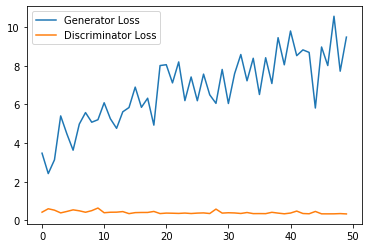

In [83]:
display_loss(generated[1],generated[2])

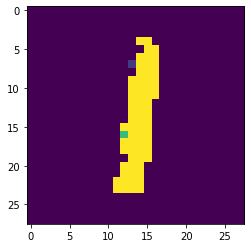

In [88]:
display_image(generated[0][49])

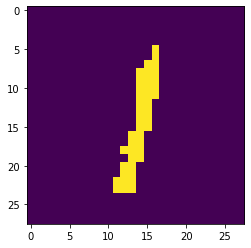

In [96]:
with torch.no_grad():
    gen.eval()
    img = gen(2*torch.randn(1, gen_input) - 1)
    display_image(img)